# Thermogram fitting

This notebook provides a example how to fit a thermogram for a multi-stage decomposition. Polyvinylchloride pyrolysis shows a characteristic 2-stage decomposition:

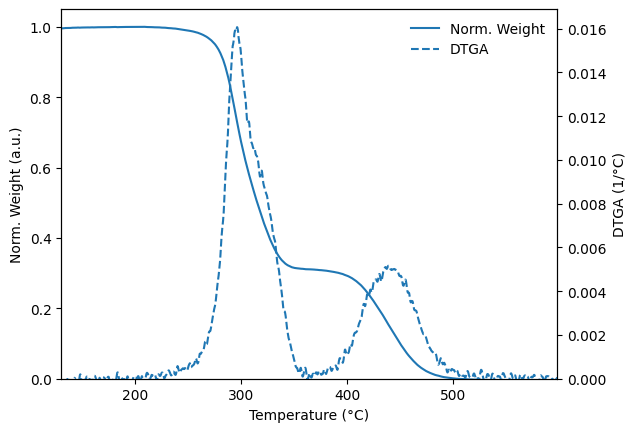

In [1]:
import pyTGA as tga
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from scipy.special import erf
import os
#laoding the data
data_dir = os.path.abspath(os.path.join(os.getcwd(), '..', '..', '..', 'example_data'))
pvc_exp = tga.parse_txt(os.path.join(data_dir, 'PVC.txt'), exp_type='general')
pvc_exp = tga.calc_DTGA_stage(pvc_exp, stage_name='stage4', x='Temp', y='relative')
data = pvc_exp.stages['stage4']
data['norm. weight'] = data['Unsubtracted weight']/data['Unsubtracted weight'].max()

#plotting
fig, ax = plt.subplots()
ax2 = ax.twinx()
ax.plot(data['Sample Temp.'], data['norm. weight'], label='Norm. Weight')
ax2.plot(data['Sample Temp.'], data['DTGA_Temp_relative'], label='DTGA', linestyle='--')
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Norm. Weight (a.u.)')
ax2.set_ylabel('DTGA (1/°C)')

ax.set_ylim(0,)
ax2.set_ylim(0,)
ax.set_xlim(data['Sample Temp.'].min(), data['Sample Temp.'].max())
fig.legend(loc='upper right', bbox_to_anchor=(1, 1), bbox_transform=ax.transAxes, frameon=False)
plt.show()

To fit the thermogram, we first set up a model. For this we are going to use the sum of two modified error functions with a step location ($x_0$) and a width ($\sigma$) (Eq.1): 

\begin{equation}
0.5 \cdot \left(1 - \text{erf}\left(\frac{x - x_0}{\sigma \sqrt{2}}\right)\right)
\end{equation}

In [2]:
from scipy.special import erf

def error_function_desc_full(x, center=0, sigma=1):
    """ Error function for a descending curve form 1 to 0 with center and sigma (width).
    """
    return 0.5 * (1 - erf((x - center) / (sigma * np.sqrt(2))))

def double_error_function(T, A1, T1, S1, A2, T2, S2, R):
    """ Double error function for a descending curve with two steps and a residual.
    
    parameters:
    ----------
    T: Temperature array
    A1: Amplitude of the first error function
    T1: Center of the first error function
    S1: Sigma (width) of the first error function
    A2: Amplitude of the second error function
    T2: Center of the second error function
    S2: Sigma (width) of the second error function
    R: Residual value
    """
    return A1 * error_function_desc_full(T, center=T1, sigma=S1) + A2 * error_function_desc_full(T, center=T2, sigma=S2) + R

For fitting:

fitted parameters:
A1 = 0.69
T1 = 302.73
S1 = 19.84
A2 = 0.32
T2 = 439.18
S2 = 25.33
R = -0.00


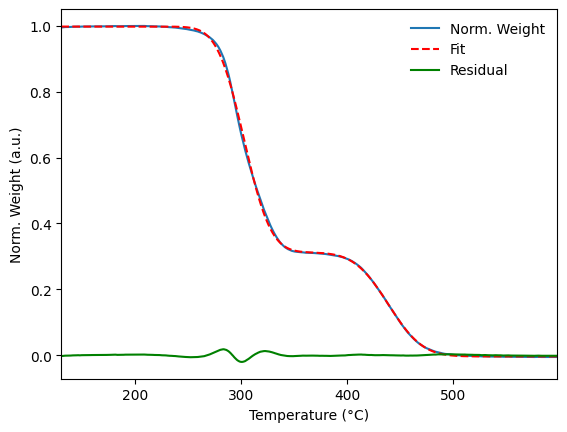

In [ ]:
from scipy.optimize import curve_fit
from scipy.optimize import Bounds

def fit_model_erf(T, A1, T1, S1, A2, T2, S2, R):
    return double_error_function(T, A1, T1, S1, A2, T2, S2, R)

# setting 
initial_guess = [ 0.5, 300, 1,
                  0.5, 450, 1,
                  data['norm. weight'].min()]

bounds = Bounds([0, -np.inf, 0, 0, -np.inf, -np.inf, -np.inf], # lower
                [1, np.inf, np.inf, 1, np.inf, np.inf, 1]) #upper



popt_erf, pcov_erf = curve_fit(fit_model_erf, data['Sample Temp.'], data['norm. weight'], p0=initial_guess, bounds=bounds)
# Extract fitted parameters
A1_erf, T1_erf, S1_erf, A2_erf, T2_erf, S2_erf, R_erf = popt_erf

digits = 2
print("fitted parameters:")
for param, value in zip(['A1', 'T1', 'S1', 'A2', 'T2', 'S2', 'R'], popt_erf):
    print(f"{param} = {value:.{digits}f}")

# Plot the original data and the fitted curve with residuals
fig, ax = plt.subplots()

ax.plot(data['Sample Temp.'], data['norm. weight'], label='Norm. Weight')

# Plot fitted curve
ax.plot(data['Sample Temp.'], fit_model_erf(data['Sample Temp.'], *popt_erf), 'r--', label='Fit')

# Calculate and plot residuals on secondary axis
residuals_erf = data['norm. weight'] - fit_model_erf(data['Sample Temp.'], *popt_erf)
ax.plot(data['Sample Temp.'], residuals_erf, 'g-', label='Residual')


ax.set_xlim(data['Sample Temp.'].min(), data['Sample Temp.'].max())
ax.set_xlabel('Temperature (°C)')
ax.set_ylabel('Norm. Weight (a.u.)')
ax.legend(frameon=False)
plt.show()

If you would like to have thermogram fitting implemented in the package itself, please bring it up as a suggestion in the issues.